In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import multivariate_normal

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

Text(0, 0.5, 'Throughput (mb/s)')

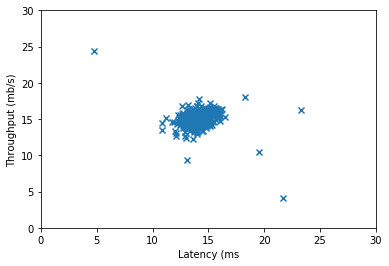

In [3]:
plt.scatter(X[:,0], X[:,1], marker='x')
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('Latency (ms')
plt.ylabel('Throughput (mb/s)')

In [4]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    
    m = X.shape[0]
    
    #compute mean
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance
    var = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,var

In [5]:
mu, sigma2 = estimateGaussian(X)

In [6]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma2=np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

In [7]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    best_epi = 0
    best_F1 = 0
    
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis]
        tp = np.sum(predictions[yval==1]==1)
        fp = np.sum(predictions[yval==0]==1)
        fn = np.sum(predictions[yval==1]==0)
        
        # compute precision, recall and F1
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        
        F1 = (2*prec*rec)/(prec+rec)
        
        if F1 > best_F1:
            best_F1 =F1
            best_epi = epi
        
    return best_epi, best_F1

In [8]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)

Best epsilon found using cross-validation: 8.990852779269495e-05
Best F1 on Cross Validation Set: 0.8750000000000001


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


## Movie Recommender System

In [9]:
data3 = loadmat('data/ex8_movies.mat')
data4 = loadmat('data/ex8_movieParams.mat')
Y = data3['Y'] # 1682 X 943 matrix, containing ratings (1-5) of 1682 movies on 943 users
R = data3['R'] # 1682 X 943 matrix, where R(i,j) = 1 if and only if user j give rating to movie i
X = data4['X'] # 1682 X 10 matrix , num_movies X num_features matrix of movie features
Theta = data4['Theta'] # 943 X 10 matrix, num_users X num_features matrix of user features

In [10]:
# Compute average rating 
print("Average rating for movie 1 (Toy Story):",np.sum(Y[0,:]*R[0,:])/np.sum(R[0,:]),"/5")

Average rating for movie 1 (Toy Story): 3.8783185840707963 /5


Text(0, 0.5, 'Movies')

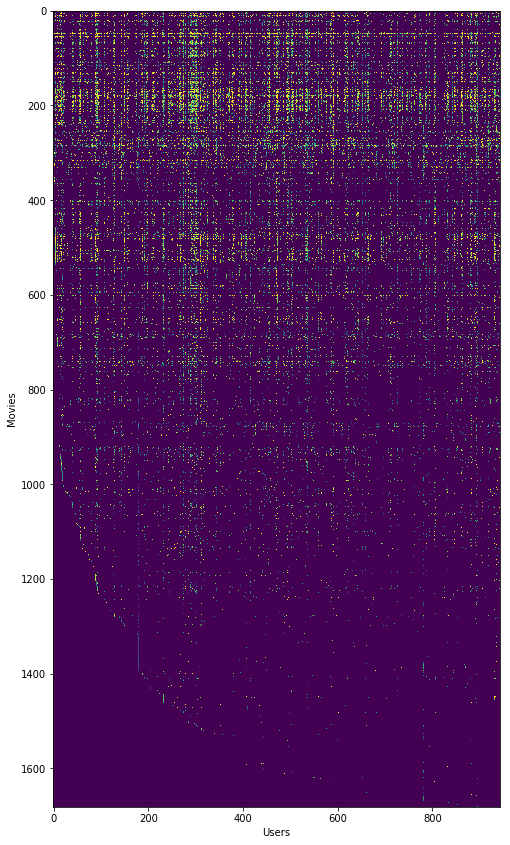

In [11]:
plt.figure(figsize=(8,16))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies")

Collaborative Filtering Learning Algorithm
$J(x^{(i)},...,x^{(n_m)},\Theta^{(I)},...,\Theta^{(n_u)}) = \frac{1}{2} \sum ((\Theta^{(j)})^Tx^{(i)} - y^{(i,j)})^2 + (\frac{\lambda}{2} \sum^{n_u}_{j=1}\sum^n_{k=1} (\Theta^{(j)}_k)^2) + (\frac{\lambda}{2} \sum^{n_m}_{i=1}\sum^n_{k=1} (x^{(i)}_k)^2)$

$\frac{\partial J}{\partial x^{(i)}_k} = \sum ((\Theta^{(j)})^Tx^{(i)} - y^{(i,j)})\Theta_k^{(j)} +\lambda x^{(i)}_k$

$\frac{\partial J}{\partial \Theta^{(j)}_k} = \sum ((\Theta^{(j)})^Tx^{(i)} - y^{(i,j)})x_k^{(i)} +\lambda \Theta^{(j)}_k$

In [12]:
def  cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering problem
    """
    
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    # predictions = yHat | gives the predicted rating values
    predictions =  X @ Theta.T
    # Predicted minus actual
    err = (predictions - Y)
    # square the predicted minus actual and multiply by R (0,1) if that user has rated that movie
    # Then sum all values, many will be 0 because of R
    # Note this is cost without regularization
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In [13]:
# Reduce the data set size to run faster
num_users, num_movies, num_features = 4,5,3
X_test = X[:num_movies,:num_features]
Theta_test= Theta[:num_users,:num_features]
Y_test = Y[:num_movies,:num_users]
R_test = R[:num_movies,:num_users]
params = np.append(X_test.flatten(),Theta_test.flatten())

# Evaluate cost function
J, grad = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, 0)[:2]
print("Cost at loaded parameters:",J)

J2, grad2 = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, 1.5)[2:]
print("Cost at loaded parameters (lambda = 1.5):",J2)

Cost at loaded parameters: 22.224603725685675
Cost at loaded parameters (lambda = 1.5): 31.34405624427422


In [14]:
# load movie list
with open('data/movie_ids.txt',mode='r', encoding='ISO-8859-1') as movieFile:
    movieList = movieFile.read().split('\n')[:-1]
#movieList = open("data/movie_ids.txt","r").read().split("\n")[:-1]

# see movie list
#np.set_printoptions(threshold=np.nan)
movieList

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

In [15]:
# Initialize my ratings
my_ratings = np.zeros((1682,1))

# Create own ratings
my_ratings[11] = 5 
my_ratings[53] = 5
my_ratings[67] = 5
my_ratings[71]= 5
my_ratings[53] = 4
my_ratings[63]= 2
my_ratings[65]= 1
my_ratings[68] = 5
my_ratings[82]= 4
my_ratings[225] = 5
my_ratings[354]= 5

print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i]>0:
        print("Rated",int(my_ratings[i]),"for index",movieList[i])

New user ratings:

Rated 5 for index 12 Usual Suspects, The (1995)
Rated 4 for index 54 Outbreak (1995)
Rated 2 for index 64 Shawshank Redemption, The (1994)
Rated 1 for index 66 While You Were Sleeping (1995)
Rated 5 for index 68 Crow, The (1994)
Rated 5 for index 69 Forrest Gump (1994)
Rated 5 for index 72 Mask, The (1994)
Rated 4 for index 83 Much Ado About Nothing (1993)
Rated 5 for index 226 Die Hard 2 (1990)
Rated 5 for index 355 Sphere (1998)


In [16]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros((m,n))
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:])/np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:]==1] = Y[i,R[i,:]==1] - Ymean[i]
        
    return Ynorm, Ymean

In [17]:
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    Optimize X and Theta
    """
    # unfold the parameters
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        params = np.append(X.flatten(),Theta.flatten())
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        X = X - (alpha * X_grad)
        Theta = Theta - (alpha * Theta_grad)
        J_history.append(cost)
    
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

In [18]:
Y = np.hstack((my_ratings,Y))
# boolean expression that evaluates to 1's and 0's
R = np.hstack((my_ratings!=0,R))

# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

In [19]:
num_movies, num_users = Y.shape
num_features = 10

# Set initial Parameters (Theta,X)
# sampled from the standard normal distribution (Gaussian) with mean 0 and sigma^2 1
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.append(X.flatten(),Theta.flatten())
Lambda = 10

# Optimize parameters using Gradient Descent
paramsFinal, J_history = gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,0.001,400,Lambda)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

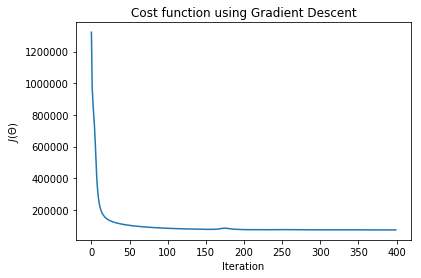

In [20]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [21]:
# unfold paramaters
X = paramsFinal[:num_movies*num_features].reshape(num_movies,num_features)
Theta = paramsFinal[num_movies*num_features:].reshape(num_users,num_features)

# Predict rating
p = X @ Theta.T
my_predictions = p[:,0][:,np.newaxis] + Ymean

In [22]:
import pandas as pd
# Load my predicted ratings and  the movie list into a pandas dataframe
df = pd.DataFrame(np.hstack((my_predictions,np.array(movieList)[:,np.newaxis])))
# sort data by the rating column
df.sort_values(by=[0],ascending=False,inplace=True)
# recreate index b
df.reset_index(drop=True,inplace=True)

In [23]:
print("Top recommendations for you:\n")
for i in range(10):
    print("Predicting rating",round(float(df[0][i]),1)," for index",df[1][i])

Top recommendations for you:

Predicting rating 8.2  for index 318 Schindler's List (1993)
Predicting rating 8.2  for index 64 Shawshank Redemption, The (1994)
Predicting rating 8.2  for index 313 Titanic (1997)
Predicting rating 8.1  for index 12 Usual Suspects, The (1995)
Predicting rating 8.1  for index 174 Raiders of the Lost Ark (1981)
Predicting rating 8.0  for index 127 Godfather, The (1972)
Predicting rating 8.0  for index 272 Good Will Hunting (1997)
Predicting rating 7.9  for index 172 Empire Strikes Back, The (1980)
Predicting rating 7.9  for index 408 Close Shave, A (1995)
Predicting rating 7.9  for index 195 Terminator, The (1984)
